# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [1]:
import torch

In [2]:
torch.__version__

'1.12.1'

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from sklearn.manifold import TSNE

In [4]:
dset=Planetoid('tutorial',name='Cora',transform=NormalizeFeatures())

In [5]:
print(f'Dataset: {dset}:')
print(f'Number of graphs: {len(dset)}')
print(f'Number of features: {dset.num_features}')
print(f'Number of classes: {dset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [10]:
dataset=dset[0]
dataset

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [11]:
dataset.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [7]:
import torch
from torch import nn
from torch.nn.functional import relu, dropout
import matplotlib.pyplot as plt

In [8]:
class MLP(nn.Module):
    def __init__(self,hidden_chan=512):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1=nn.Linear(dset.num_features,hidden_chan)
        self.lin2=nn.Linear(hidden_chan,dset.num_classes)
        
    def forward(self,x):
        x=relu(self.lin1(x))
        x = dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x
    
def train(model,data=dataset,epochs=100, verbose=True):
    loss_list=[]
    for epoch in range(epochs):
        optimizer.zero_grad()
        out=model(data.x)
        loss=criterion(out[data.train_mask],data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if verbose : print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        loss_list.append(loss.detach().numpy())
    return loss_list
        
def test(model,data):
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    

In [9]:
model = MLP(hidden_chan=16)
print(model)
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


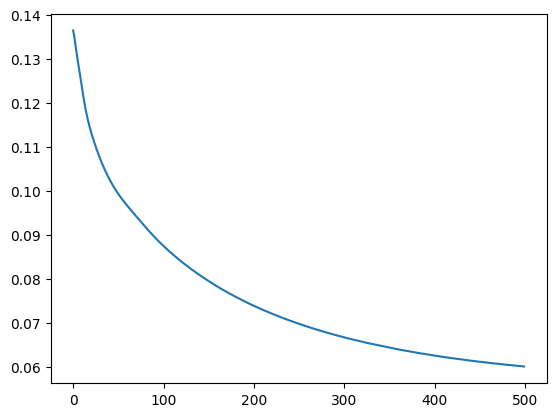

In [96]:
loss=train(model=model,data=dataset,epochs=500,verbose=False)
plt.plot(loss)

In [97]:
test_acc=test(model,data=dataset)
print(test_acc)

0.605


In [12]:
from torch_geometric.nn import GCNConv
from torch.nn.functional import softmax,elu

In [13]:
class GNN(nn.Module):
    def __init__(self,hidden_chan=16):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1=GCNConv(dset.num_features,hidden_chan)
        self.conv2=GCNConv(hidden_chan,dset.num_classes)
        
    def forward(self,x,edges):
        x=relu(self.conv1(x,edges))
        x =dropout(x, p=0.5, training=self.training)
        x=self.conv2(x,edges)
        return x
    
def train_gnn(model,data=dataset,epochs=100, verbose=True):
    loss_list=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out=model(data.x,data.edge_index)
        loss=criterion(out[data.train_mask],data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if verbose : print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        loss_list.append(loss.detach().item())
    return loss_list
        
def test_gnn(model,data):
    model.eval()
    out = model(data.x,data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [14]:
model_gnn=GNN()
print(model_gnn)

GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [18]:
out[0]

tensor([-0.0029, -0.0023, -0.0038, -0.0011, -0.0016,  0.0011, -0.0060],
       grad_fn=<SelectBackward0>)

C:\Users\bdutta\anaconda3\envs\pyg\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\bdutta\anaconda3\envs\pyg\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


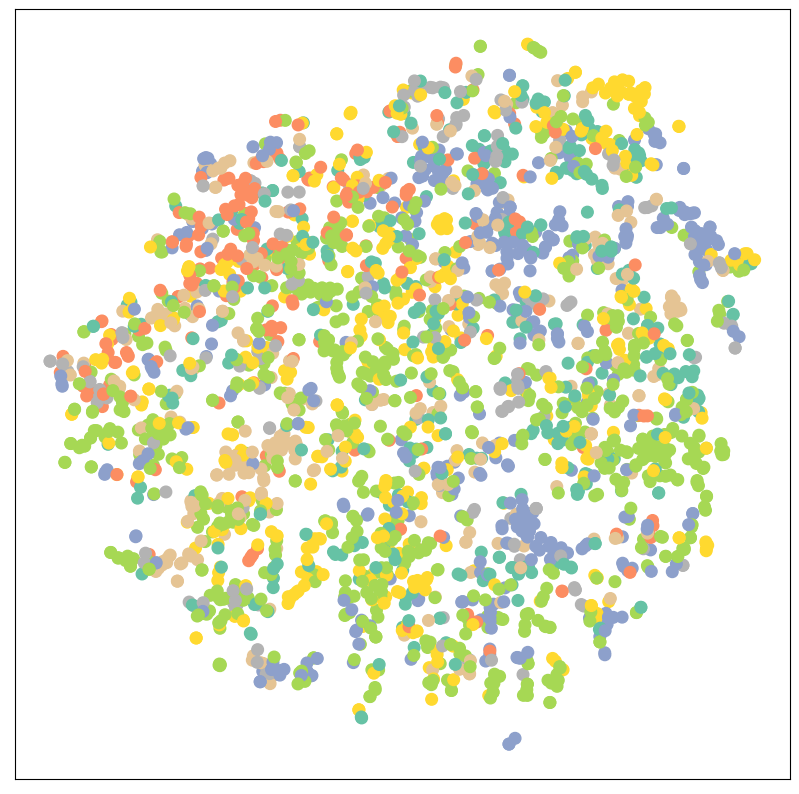

In [15]:
model_gnn.eval()
out=model_gnn(dataset.x,dataset.edge_index)
visualize(out,dataset.y)

Epoch: 000, Loss: 1.9460
Epoch: 001, Loss: 1.9403
Epoch: 002, Loss: 1.9343
Epoch: 003, Loss: 1.9269
Epoch: 004, Loss: 1.9192
Epoch: 005, Loss: 1.9110
Epoch: 006, Loss: 1.9018
Epoch: 007, Loss: 1.8922
Epoch: 008, Loss: 1.8819
Epoch: 009, Loss: 1.8709
Epoch: 010, Loss: 1.8591
Epoch: 011, Loss: 1.8472
Epoch: 012, Loss: 1.8346
Epoch: 013, Loss: 1.8215
Epoch: 014, Loss: 1.8078
Epoch: 015, Loss: 1.7935
Epoch: 016, Loss: 1.7785
Epoch: 017, Loss: 1.7631
Epoch: 018, Loss: 1.7470
Epoch: 019, Loss: 1.7304
Epoch: 020, Loss: 1.7132
Epoch: 021, Loss: 1.6954
Epoch: 022, Loss: 1.6772
Epoch: 023, Loss: 1.6584
Epoch: 024, Loss: 1.6390
Epoch: 025, Loss: 1.6191
Epoch: 026, Loss: 1.5986
Epoch: 027, Loss: 1.5776
Epoch: 028, Loss: 1.5560
Epoch: 029, Loss: 1.5339
Epoch: 030, Loss: 1.5113
Epoch: 031, Loss: 1.4882
Epoch: 032, Loss: 1.4647
Epoch: 033, Loss: 1.4408
Epoch: 034, Loss: 1.4165
Epoch: 035, Loss: 1.3920
Epoch: 036, Loss: 1.3671
Epoch: 037, Loss: 1.3420
Epoch: 038, Loss: 1.3168
Epoch: 039, Loss: 1.2914


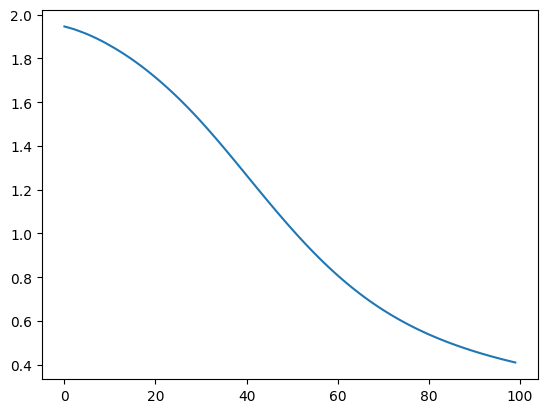

In [19]:
loss_gnn=train_gnn(model=model_gnn,data=dataset,epochs=100)
plt.plot(loss_gnn)

In [20]:
test_gnn(model_gnn,dataset)

0.82

C:\Users\bdutta\anaconda3\envs\pyg\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\bdutta\anaconda3\envs\pyg\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


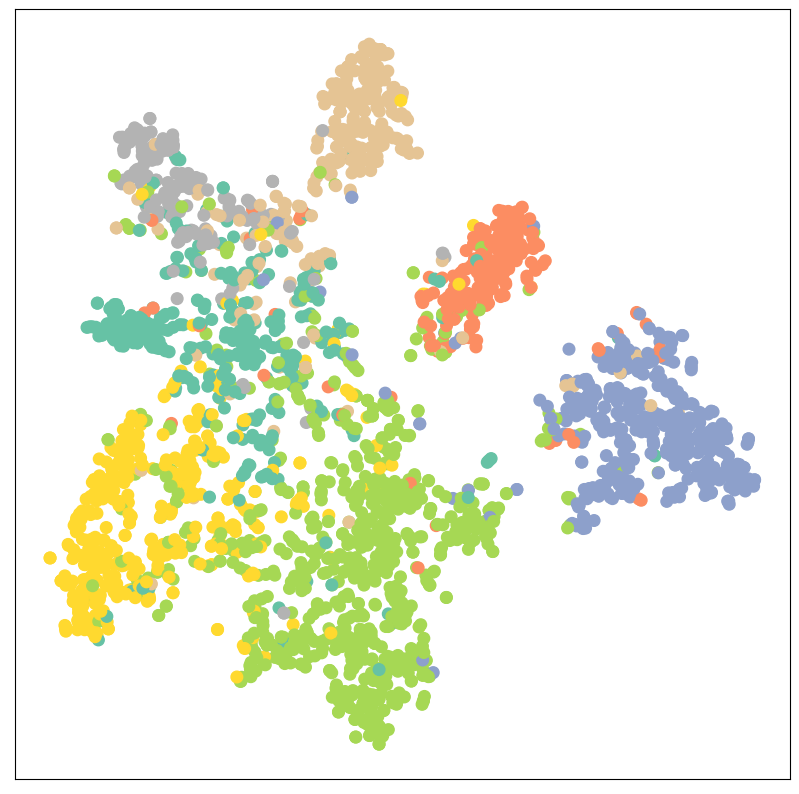

In [21]:
model.eval()
out=model_gnn(dataset.x,dataset.edge_index)
visualize(out,dataset.y)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [22]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dset.num_features,hidden_channels,heads)  # TODO
        self.conv2 = GATConv(hidden_channels*heads,dset.num_classes,heads)  # TODO

    def forward(self, x, edge_index):
        x = dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = elu(x)
        x = dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

data=dataset
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
     
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.1540, Test: 0.1660
Epoch: 002, Loss: 3.9907, Val: 0.1240, Test: 0.1310
Epoch: 003, Loss: 3.9534, Val: 0.0960, Test: 0.1100
Epoch: 004, Loss: 3.9121, Val: 0.0860, Test: 0.1020
Epoch: 005, Loss: 3.8659, Val: 0.0840, Test: 0.0920
Epoch: 006, Loss: 3.8015, Val: 0.0780, Test: 0.0890
Epoch: 007, Loss: 3.7434, Val: 0.0680, Test: 0.0800
Epoch: 008, Loss: 3.6690, Val: 0.0660, Test: 0.0760
Epoch: 009, Loss: 3.6004, Val: 0.0640, Test: 0.0740
Epoch: 010, Loss: 3.5158, Val: 0.0640, Test: 0.0720
Epoch: 011, Loss: 3.4187, Val: 0.0620, Test: 0.0710
Epoch: 012, Loss: 3.3205, Val: 0.0600, Test: 0.0690
Epoch: 013, Loss: 3.2355, Val: 0.0580, Test: 0.0670
Epoch: 014, Loss: 3.1221, Val: 0.0580, Test: 0.0670
Epoch: 015, Loss: 2.9988, Val: 0.0580, Test: 0.0670
Epoch: 016, Loss: 2.8735, Val: 0.0580, Test: 0.0660
Epoch: 017, Loss: 2.7678, Val: 0.0580, Test: 0.0660
Epoch: 018, Loss: 2.6441, Val: 0.0580

Epoch: 159, Loss: 0.6619, Val: 0.8020, Test: 0.8070
Epoch: 160, Loss: 0.6742, Val: 0.8020, Test: 0.8050
Epoch: 161, Loss: 0.6740, Val: 0.8020, Test: 0.8060
Epoch: 162, Loss: 0.6105, Val: 0.8020, Test: 0.8060
Epoch: 163, Loss: 0.6166, Val: 0.7980, Test: 0.8020
Epoch: 164, Loss: 0.6195, Val: 0.7980, Test: 0.8030
Epoch: 165, Loss: 0.6195, Val: 0.8000, Test: 0.8040
Epoch: 166, Loss: 0.5828, Val: 0.8020, Test: 0.8060
Epoch: 167, Loss: 0.6212, Val: 0.8000, Test: 0.8100
Epoch: 168, Loss: 0.5539, Val: 0.8000, Test: 0.8080
Epoch: 169, Loss: 0.6208, Val: 0.7980, Test: 0.8100
Epoch: 170, Loss: 0.5736, Val: 0.7980, Test: 0.8100
Epoch: 171, Loss: 0.6495, Val: 0.7980, Test: 0.8090
Epoch: 172, Loss: 0.5515, Val: 0.8000, Test: 0.8120
Epoch: 173, Loss: 0.6146, Val: 0.8020, Test: 0.8120
Epoch: 174, Loss: 0.5858, Val: 0.8020, Test: 0.8110
Epoch: 175, Loss: 0.5580, Val: 0.8020, Test: 0.8120
Epoch: 176, Loss: 0.6121, Val: 0.8020, Test: 0.8150
Epoch: 177, Loss: 0.5594, Val: 0.8020, Test: 0.8150
Epoch: 178, 

In [141]:
out = model(data.x, data.edge_index) 

In [139]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])